In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV


In [2]:
stock_news_data = pd.read_csv("AAPL_data.csv")
nan_counts = stock_news_data.isna().sum()
print(nan_counts)
stock_news_data['5-Moving Average'] = stock_news_data['Adj Close'].rolling(window=5).mean()
stock_news_data['20-Moving Average'] = stock_news_data['Adj Close'].rolling(window=20).mean()
stock_news_data['Sentiment 5-Moving Average'] = stock_news_data['headline_score'].rolling(window=5).mean()
stock_news_data['Sentiment 20-Moving Average'] = stock_news_data['headline_score'].rolling(window=20).mean()
stock_news_data = stock_news_data.dropna()

Date                0
Open                0
High                0
Low                 0
Adj Close           0
Volume              0
Prev Day            1
Target              0
Adj Close Change    1
headline_score      0
dtype: int64


In [3]:
# Assume df is your DataFrame
scaler = MinMaxScaler()
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume', 'headline_score', '5-Moving Average','20-Moving Average', 'Sentiment 5-Moving Average','Sentiment 20-Moving Average']
y = stock_news_data[['Target']].copy()[1:].values.flatten()
X = scaler.fit_transform(stock_news_data[features])[:-1]
print(X.shape)
print(y.shape)


(230, 10)
(230,)


In [4]:
split_ratio = 0.7
split_point = int(len(X) * split_ratio)

# Split the data into training and testing sets
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]
print(X_test.shape)
print(y_test.shape)

(69, 10)
(69,)


In [5]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [ ]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=rf_param_grid, cv=3, verbose=0, n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

In [ ]:
gbm_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
gbm_grid_search = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), param_grid=gbm_param_grid, cv=3, verbose=0, n_jobs=-1)
gbm_grid_search.fit(X_train, y_train)

In [12]:
print("Best parameters for Random Forest:", rf_grid_search.best_params_)
print("Best score for Random Forest: {:.2f}%".format(rf_grid_search.best_score_ * 100))

rf_best = rf_grid_search.best_estimator_
gbm_best = gbm_grid_search.best_estimator_

rf_predictions = rf_best.predict(X_test)
gbm_predictions = gbm_best.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_predictions)
gbm_accuracy = accuracy_score(y_test, gbm_predictions)

print("Test accuracy for Random Forest: {:.2f}%".format(rf_accuracy * 100))
print("Test accuracy for GBM: {:.2f}%".format(gbm_accuracy * 100))


Best parameters for Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best score for Random Forest: 28.59%
Test accuracy for Random Forest: 59.42%
Test accuracy for GBM: 42.03%


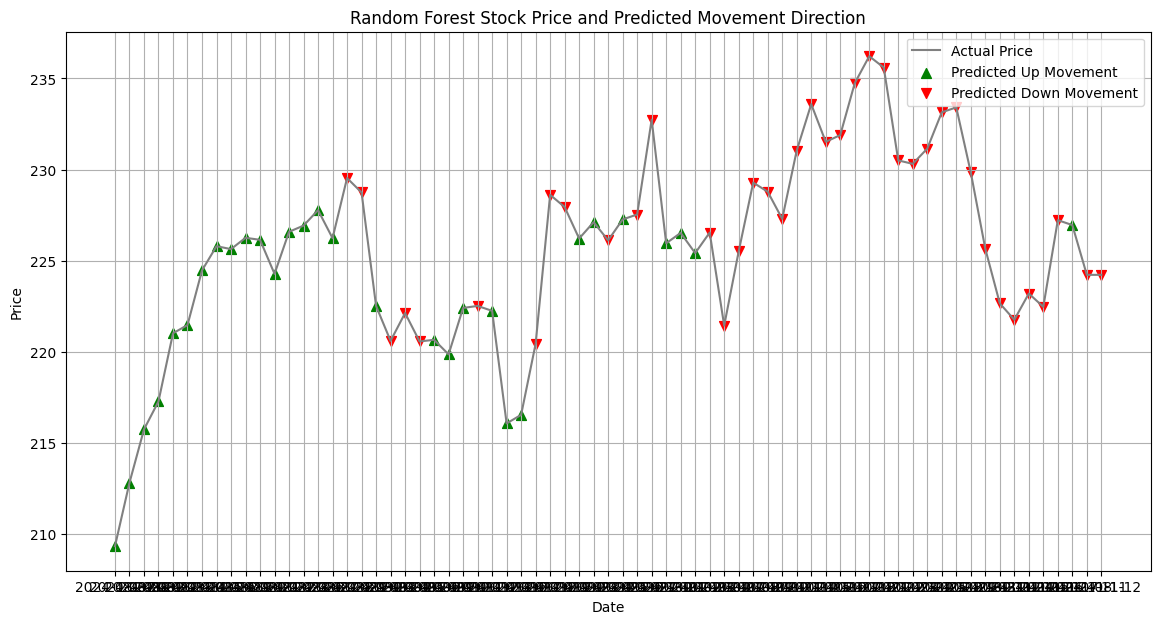

In [10]:
test = stock_news_data[['Date', 'Adj Close']][split_point:-1]
predicted_movements = pd.DataFrame({
    'Date': test['Date'],
    'Predicted_Movement': rf_predictions
})

# Merge predictions with the original price data
results = pd.merge(test, predicted_movements, on='Date', how='left')

plt.figure(figsize=(14, 7))
plt.plot(results['Date'], results['Adj Close'], label='Actual Price', color='gray')

# Highlight the predicted up and down movements
up_movement = results[results['Predicted_Movement'] == 1]
down_movement = results[results['Predicted_Movement'] == 0]

plt.scatter(up_movement['Date'], up_movement['Adj Close'], color='green', label='Predicted Up Movement', marker='^', s=50)
plt.scatter(down_movement['Date'], down_movement['Adj Close'], color='red', label='Predicted Down Movement', marker='v', s=50)

plt.title('Random Forest Stock Price and Predicted Movement Direction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

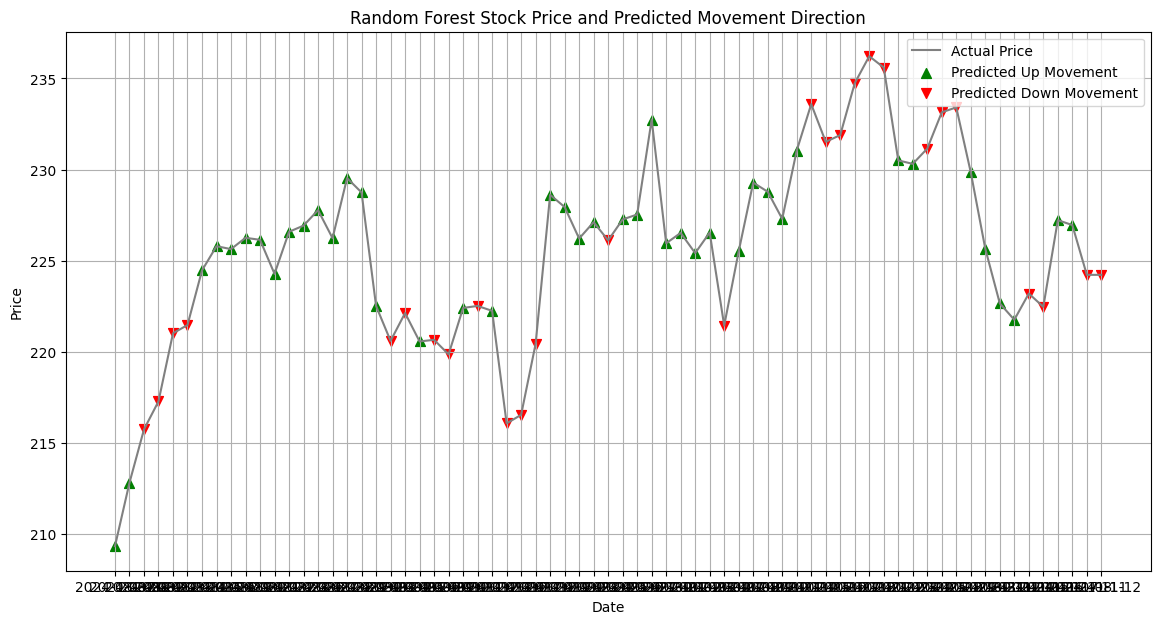

In [11]:
test = stock_news_data[['Date', 'Adj Close']][split_point:-1]
predicted_movements = pd.DataFrame({
    'Date': test['Date'],
    'Predicted_Movement': gbm_predictions
})

# Merge predictions with the original price data
results = pd.merge(test, predicted_movements, on='Date', how='left')

plt.figure(figsize=(14, 7))
plt.plot(results['Date'], results['Adj Close'], label='Actual Price', color='gray')

# Highlight the predicted up and down movements
up_movement = results[results['Predicted_Movement'] == 1]
down_movement = results[results['Predicted_Movement'] == 0]

plt.scatter(up_movement['Date'], up_movement['Adj Close'], color='green', label='Predicted Up Movement', marker='^', s=50)
plt.scatter(down_movement['Date'], down_movement['Adj Close'], color='red', label='Predicted Down Movement', marker='v', s=50)

plt.title('Random Forest Stock Price and Predicted Movement Direction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()